In [2]:
import pandas as pd
from scipy import stats
import qnorm
from scipy.stats import wilcoxon

In [3]:
#input data 가져오기
df = pd.read_csv("glycopeptide_change.txt",sep="\t")

In [4]:
#consensuspathdb input 생성을 위해 peptide-symbol 컬럼만 가져오기
peptide_symbol = df[["Peptide","Symbol"]]

In [5]:
#컬럼에 patient id만 남기도록 정리
df = df.set_index("Peptide")
df.drop("Symbol",axis=1,inplace=True)

# NaN이 아닌 값이 50% 이상인 행만 선정
selected_rows = df[df.count(axis=1) / len(df.columns) >= 0.5]

# 새로운 데이터프레임 생성
glyco_fch = df.loc[selected_rows.index]

In [6]:
#quantile normalization
glyco_fch_t = glyco_fch.transpose()
df =qnorm.quantile_normalize(glyco_fch_t).transpose()

In [7]:
#patient meta 정보 가져오기
mutation = pd.read_excel("SuppleTable_SomaticMutation_80_nonsyn.xls")

In [8]:
#arid1a에 돌연변이가 존재하는 patient id 가져오기
patient_id = mutation[mutation.Gene == "ARID1A"].Patient.to_list()

In [9]:
#df와 mutation의 patient id 형식 맞춰주기
arid1a = []
for item in patient_id:
    number_part, letter_part = item[:-1], item[-1]
    arid1a.append(f'N{int(number_part) - 1}{letter_part}{number_part}')

arid1a_mutated = df.columns[df.columns.isin(arid1a)]
arid1a_nomutated = df.columns[~df.columns.isin(arid1a)]

arid1a_mt_df = df[arid1a_mutated]
arid1a_wt_df = df[arid1a_nomutated]

In [10]:
#wildtype 대비 mutation이 높게 발현된것들 선별하기 위한 비교 데이터프레임
arid1a_median_df = pd.DataFrame({"wildtype":arid1a_wt_df.median(axis=1),"mutation":arid1a_mt_df.median(axis=1)})
arid1a_median_df['mt>0&wt<0'] = arid1a_median_df.apply(lambda x: "o" if (x['wildtype'] < 0) and (x['mutation'] > 0) else "x", axis=1)

In [11]:
#mannwhitneyu = wilcoxon sum test 진행
from scipy.stats import mannwhitneyu

#wilcoxon sum test 결과값을 저장할 빈 데이터프레임 생성
arid1a_wcxs_df = pd.DataFrame(columns=["col","statistic","pvalue"])

In [12]:
#mutation과 wildtype 간의 wilcoxon sum test 진행
for idx in arid1a_wt_df.index:
    wt_data = arid1a_wt_df.loc[idx].dropna().values
    mt_data = arid1a_mt_df.loc[idx].dropna().values

    if wt_data.size > 0 and mt_data.size > 0:
        statistic, p_value = mannwhitneyu(wt_data, mt_data)
        result = pd.DataFrame([[idx, statistic, p_value]], columns=["col", "statistic", "pvalue"])
        arid1a_wcxs_df = pd.concat([arid1a_wcxs_df, result], ignore_index=True)

In [13]:
#p값이 0.05보다 작은 peptide 선별
arid1a_pval_005 = arid1a_wcxs_df[arid1a_wcxs_df.pvalue < 0.05].col.to_list()

#median값이 mutation에서 0보다 크고, wildtype에서 0보다 작은 peptide 선별
arid1a_median_mt_over0_wt_under0 =arid1a_median_df[arid1a_median_df['mt>0&wt<0'] == "o"].index.to_list()

In [14]:
#median, p값 교집합 기준 유의미한 peptide 선별
arid1a_sig = list(set(arid1a_median_mt_over0_wt_under0)&set(arid1a_pval_005))
arid1a_final_input = df[df.index.isin(arid1a_sig)]

#heatmap에서 색깔로 mutation과 wildtype을 구분하기 위해 mutation과 wildtype끼리 모아서 concat
arid1a_wt = arid1a_final_input[arid1a_final_input.columns[~arid1a_final_input.columns.isin(arid1a)]]
arid1a_mt = arid1a_final_input[arid1a_final_input.columns[arid1a_final_input.columns.isin(arid1a)]]
arid1a_final = pd.concat([arid1a_mt, arid1a_wt],axis=1)

In [15]:
#heatmap을 그리기 위해 -1 ~ 1 로 스케일링
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
arid1a_final_cols = arid1a_final.columns
arid1a_final_scaler = arid1a_final.copy()
arid1a_final_scaler[arid1a_final_cols] = scaler.fit_transform(arid1a_final_scaler[arid1a_final_cols])

In [16]:
#heatmap input 저장 >> mutation_wildtype_heatmap.R 시각화
arid1a_final_scaler.to_csv("./arid1a_glyco_heatmapinput.csv",index=False)

In [18]:
#consensuspathdb input 생성을 위한 peptide-symbol match
arid1a_peptide = pd.DataFrame(arid1a_final_scaler.reset_index(),columns=["Peptide"])
pd.merge(peptide_symbol, arid1a_peptide, on="Peptide",how="inner").Symbol.to_csv("arid1a_symbol_glyco.csv",index=False)

In [19]:
#patient metadata: annotation bar inpt생성

#patient metadata 가져오기
patient_meta = pd.read_csv("clinical_info.txt",sep="\t")

#heatmap input과 동일하게 patient id 형식 맞춰주기
patient_meta["Normal"]="N"+patient_meta["Normal"].str[:-1]
patient_meta["Tumor"]="T"+patient_meta["Tumor"].str[:-1]
patient_meta["sampleID"]=patient_meta["Normal"]+patient_meta["Tumor"]

#필요한 컬럼만 가져오기
patient_meta_selected = patient_meta[["sampleID","EBV","MSI","Gender","Histology (Lauren)"]]

#arid1a에 mutation이 발생한 환자 id
arid1a = ["N117T118","N155T156","N231T232","N249T250","N33T34","N39T40","N65T66"]


In [20]:
#arid1a에 mutation 여부에 대한 환자 정보 patient_meta_selected에 컬럼 추가하기
patient_meta_selected["Mutation"] = patient_meta_selected.sampleID.apply(lambda x: "Mut" if x in arid1a else "WT")

#mutation과 wildtype을 구분해서 heatmap annotation을 그리기 위해 dataframe sorting
patient_mt = patient_meta_selected[patient_meta_selected.sampleID.isin(arid1a)]
patient_wt = patient_meta_selected[~patient_meta_selected.sampleID.isin(arid1a)]
patient_meta_sorted = pd.concat([patient_mt,patient_wt],axis=0).set_index("sampleID")

patient_meta_sorted = patient_meta_sorted.rename(columns={"Histology (Lauren)":"Histology"})

C:\Users\cofls\AppData\Local\Temp\ipykernel_18188\2986045542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_meta_selected["Mutation"] = patient_meta_selected.sampleID.apply(lambda x: "Mut" if x in arid1a else "WT")


In [21]:
patient_meta_sorted.Histology.fillna("Others",inplace=True)
patient_meta_sorted.EBV.replace("Negative","EBV-",inplace=True)
patient_meta_sorted.EBV.replace("EBV(PIK3CAmut)","EBV+",inplace=True)
patient_meta_sorted.EBV.replace("EBV","EBV+",inplace=True)
patient_meta_sorted.EBV.replace("EBV(PIK3CAwt)","EBV+",inplace=True)

patient_final= patient_meta_sorted.transpose()

patient_final.to_csv("./arid1a_glyco_patient_meta.csv",index=False)

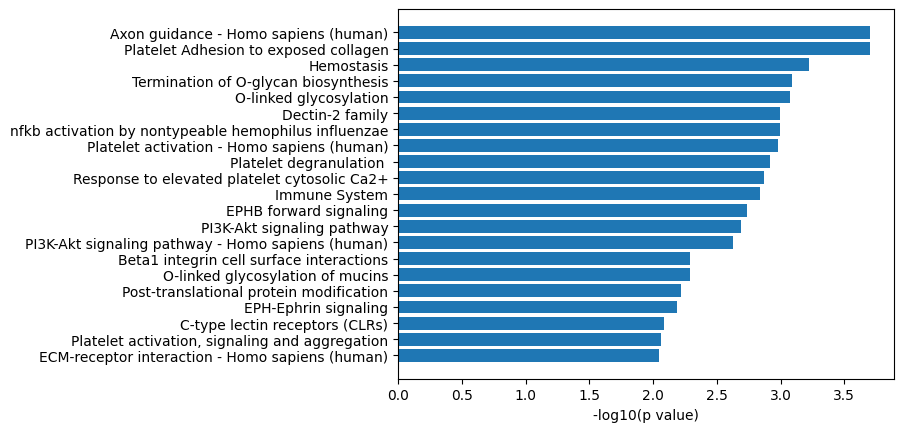

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# arid1a_symbol_glyco.csv 파일의 유전자들을 consensuspathdb에 제출, 결과 파일로 저장
# http://cpdb.molgen.mpg.de/

#consensuspathdb 결과값을 input으로 받아오기
df = pd.read_csv("./ORA_results.tab",sep="\t")

df = df[["pathway","p-value"]]  # df에 따라 df를 확인하여 df = df[["term_name","p-value"]] 와 같이 변형

#log10취하기
df["log10_pvalue"]=np.log10(df["p-value"])

#abs로 x축 양수로 만들기
df["-log10(pvalue)"] = abs(df["log10_pvalue"])

#barplot 그리기
fig, ax = plt.subplots()
name = df["pathway"][::-1]
log = df["-log10(pvalue)"][::-1]
ax.barh(name,log)
plt.xlabel('-log10(p value)')
plt.savefig("glyco-log10_enrichment.png")